# Generation of λ-Nets for I-Net training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'function_family': {
        'maximum_depth': 4,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,          
        'dt_type': 'vanilla', #'vanilla', 'SDT'
    },
    'data': {
        'number_of_variables': 10, 
        'num_classes': 2,
        'categorical_indices': [],
        'random_parameters_distribution': True, ##MAKEPATH DIFFERENT FILES
        'max_distributions_per_class': 1, # None; 0; int >= 1
        'data_generation_filtering': False,
        'fixed_class_probability': True,
        
        'function_generation_type': 'make_classification_distribution',# 'make_classification_distribution', 'make_classification_distribution_trained', 'make_classification', 'make_classification_trained', 'random_decision_tree', 'random_decision_tree_trained'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
        
        'data_noise': 0, #None or float
        'distrib_param_max': 5,
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-2,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [128],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
                
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 10000,
    },     
    'evaluation': {   
    },    
    
    'computation':{
        'n_jobs': 50,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}




In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
from more_itertools import random_product 
import pickle
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt 
import time
import math
import operator
from functools import reduce

from scipy.signal import argrelextrema

import sys

import shutil

import logging
logging.getLogger('tensorflow').disabled = True

from joblib import Parallel, delayed


from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
#from similaritymeasures import frechet_dist, area_between_two_curves, dtw
from IPython.display import Image

from livelossplot import PlotLossesKerasTF

import seaborn as sns

import tensorflow as tf
#import tensorflow_addons as tfa
import random 


#import keras
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



In [4]:
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################
    
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)

In [5]:
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)

#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='lambda_net'))
generate_directory_structure()
generate_lambda_net_directory(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [6]:
print(path_identifier_lambda_net_data)

print(path_identifier_function_data)


lNetSize5000_numLNets10000_var10_class2_make_classification_distribution_xMax1_xMin0_xDistuniform_dNoise0_randParamDist_maxDistClass1_distribParamMax5_filterGen_depth4_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42
lNetSize5000_numDatasets10000_var10_class2_make_classification_distribution_xMax1_xMin0_xDistuniform_dNoise0_randParamDist_maxDistClass1_distribParamMax5_filterGen_depth4_beta1_decisionSpars1_vanilla_fullyGrown


In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


In [8]:
lambda_network_layers

[128]

In [9]:
path_functions = './data/saved_function_lists/functions_' + path_identifier_function_data + '.csv'
function_df = pd.read_csv(path_functions)

path_X_data = './data/saved_function_lists/X_data_' + path_identifier_function_data + '.pkl'
with open(path_X_data, 'rb') as f:
    X_data_list = pickle.load(f)
    
path_y_data = './data/saved_function_lists/y_data_' + path_identifier_function_data + '.pkl'
with open(path_y_data, 'rb') as f:
    y_data_list = pickle.load(f)
    
try:
    path_distribution = './data/saved_function_lists/distribution_parameter_list_list_' + path_identifier_function_data + '.pkl'
    with open(path_distribution, 'rb') as f:
        distribution_parameter_list_list = pickle.load(f)
except Exception:
    traceback.print_exc()
    distribution_parameter_list_list = [[None, None]]*number_of_generated_datasets
    
if number_of_trained_lambda_nets < number_of_generated_datasets:
    function_df = function_df.sample(n=number_of_trained_lambda_nets, random_state=RANDOM_SEED)
    random.seed(RANDOM_SEED)
    X_data_list = random.sample(X_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)
    y_data_list = random.sample(y_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)
    try:
        distribution_parameter_list_list = random.sample(distribution_parameter_list_list, number_of_trained_lambda_nets)
        random.seed(RANDOM_SEED)
    except:
        distribution_parameter_list_list = [[None, None]]*number_of_trained_lambda_nets

## Data Inspection

In [10]:
function_df.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,split0,split1,split2,split3,split4,split5,split6,split7,split8,split9,split10,split11,split12,split13,split14,lp0,lp1,lp2,lp3,lp4,lp5,lp6,lp7,lp8,lp9,lp10,lp11,lp12,lp13,lp14,lp15
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
X_data_list[0][0].head(10)

feat0    0
feat1    0
feat2    0
feat3    0
feat4    0
feat5    0
feat6    0
feat7    0
feat8    0
feat9    0
dtype: int64

In [12]:
X_data_list[0][1].head(10)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,0.664,0.265,0.500,0.748,0.055,0.819,0.499,0.417,0.664,0.500
1,0.538,0.283,0.333,0.347,0.212,0.692,0.120,0.504,0.538,0.333
2,0.250,0.405,0.167,0.628,0.106,0.120,0.589,0.484,0.250,0.167
3,0.550,0.598,0.167,0.663,0.006,0.540,0.313,0.450,0.550,0.167
4,0.445,0.790,0.333,0.456,0.004,0.729,0.309,0.680,0.445,0.333
5,0.286,0.864,0.167,0.531,0.076,0.553,0.704,0.319,0.286,0.167
6,0.709,0.753,0.333,0.653,0.199,0.949,0.732,0.460,0.709,0.333
7,0.214,0.941,0.167,0.316,0.036,0.101,0.830,0.417,0.214,0.167
8,0.769,0.782,0.167,0.420,0.026,0.722,0.282,0.195,0.769,0.167
9,0.949,0.421,0.333,0.515,0.126,0.824,0.689,0.341,0.949,0.333


In [13]:
y_data_list[0][0].head(10)

feat0    0
feat1    0
feat2    0
feat3    0
feat4    0
feat5    0
feat6    0
feat7    0
feat8    0
feat9    0
dtype: int64

In [14]:
y_data_list[0][1].head(10)

,result
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


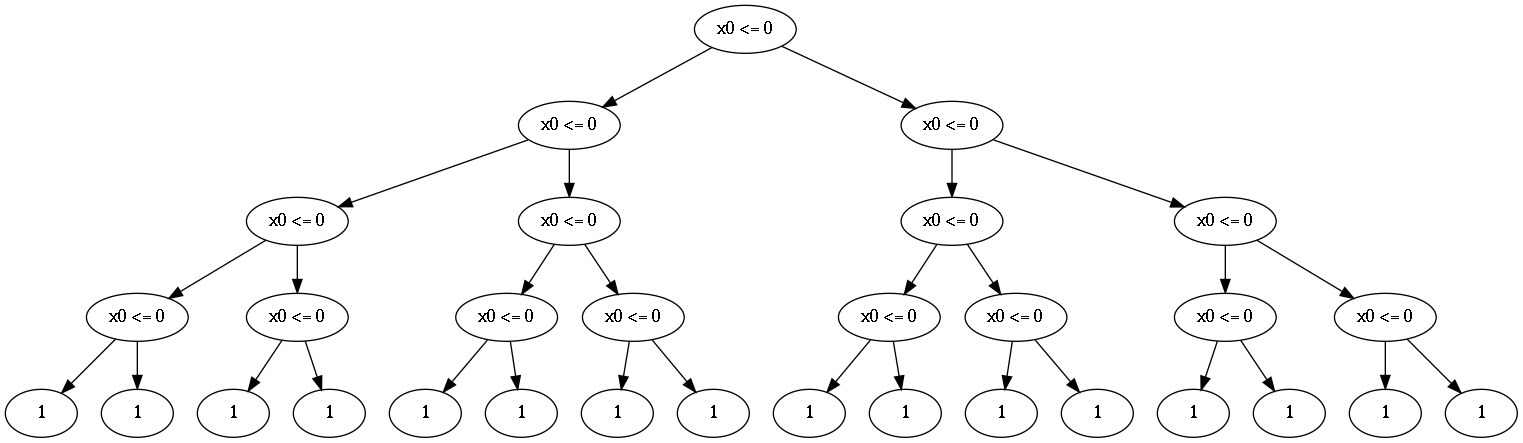

In [15]:
plot = None
if plot_tree_from_parameters != 'make_classification':
    plot = plot_tree_from_parameters(y_data_list[0][0].values, config)
plot

In [16]:
def inject_noise(y_data, noise=0.0, noise_dist='normal', seed=42):
    """
    Returns a polynomial injected with specified noise type and amount. 
    Inputs a clean polynomial array with x-data and y-data and modifies the y-data according to the noise settings.
    """
    np.random.seed(seed)
    
    #Calculate range of function values of input polynomial
    range_values_fv = np.ptp(y_data[1].values)
    
    #Selection of noise type
    #Available types: normal, uniform, A, B, C
    if noise_dist=='normal':
        noise_sample=noise*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform':
        noise_sample=noise*np.random.uniform(low=0, high=1.0,size=y_data[1].shape[0])
    elif noise_dist=='normal_range':
        #Normal distribution adjusted to function value range
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform_range':
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='flip_percentage':
        idx = np.random.choice(y_data[1].shape[0], int(y_data[1].shape[0]*noise), replace=False)
        y_data[1].iloc[idx] = (y_data[1].iloc[idx] + 1) % 2 
        return y_data
    else:
        #no noise
        noise_sample = np.zeros(y_data[1].shape[0])
                               
    noise_sample=noise_sample.reshape(-1,1)
    
    y_data[1]=y_data[1]+noise_sample
    
    return np.clip(y_data, 0, 1)

In [17]:
if noise_injected_level > 0:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    y_data_list = parallel(delayed(inject_noise)(y_data=y_data_list[i],
                                                 noise=noise_injected_level,
                                                 noise_dist=noise_injected_type, 
                                                 seed=RANDOM_SEED+i) for i in range(len(y_data_list)))


In [18]:
y_data_list[0][0].head(10)

feat0    0
feat1    0
feat2    0
feat3    0
feat4    0
feat5    0
feat6    0
feat7    0
feat8    0
feat9    0
dtype: int64

In [19]:
y_data_list[0][0]

feat0      0
feat1      0
feat2      0
feat3      0
feat4      0
feat5      0
feat6      0
feat7      0
feat8      0
feat9      0
feat10     0
feat11     0
feat12     0
feat13     0
feat14     0
split0     0
split1     0
split2     0
split3     0
split4     0
split5     0
split6     0
split7     0
split8     0
split9     0
split10    0
split11    0
split12    0
split13    0
split14    0
lp0        0
lp1        0
lp2        0
lp3        0
lp4        0
lp5        0
lp6        0
lp7        0
lp8        0
lp9        0
lp10       0
lp11       0
lp12       0
lp13       0
lp14       0
lp15       0
dtype: int64

In [20]:
y_data_list[0][1].head(10)

,result
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


## Lambda Network Training + Weigh/Bias saving

In [21]:
#%load_ext autoreload

In [22]:
rand_index = np.random.randint(number_of_trained_lambda_nets)

#rand_tree = generate_decision_tree_from_array(y_data_list[rand_index][0].values, config)
#rand_tree.plot_tree()

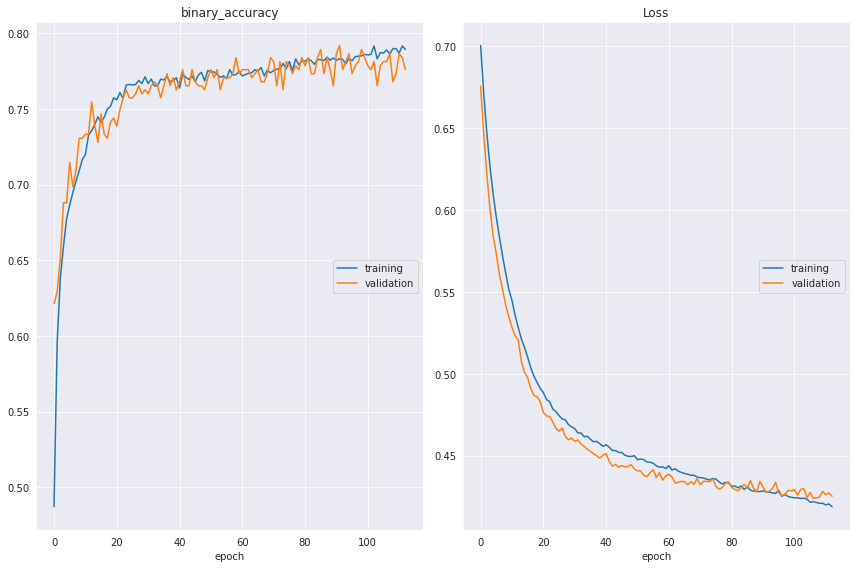

binary_accuracy
	training         	 (min:    0.487, max:    0.792, cur:    0.789)
	validation       	 (min:    0.621, max:    0.792, cur:    0.776)
Loss
	training         	 (min:    0.419, max:    0.700, cur:    0.419)
	validation       	 (min:    0.424, max:    0.676, cur:    0.425)


In [23]:
#%autoreload 2
random_network = train_lambda_net(config=config,
                                  lambda_index=rand_index, 
                                  X_data_with_function=X_data_list[rand_index], 
                                  y_data_with_function=y_data_list[rand_index], 
                                  distribution_parameter_list = distribution_parameter_list_list[rand_index][1],
                                  callbacks=[PlotLossesKerasTF()], 
                                  return_model=True,
                                  printing=False)

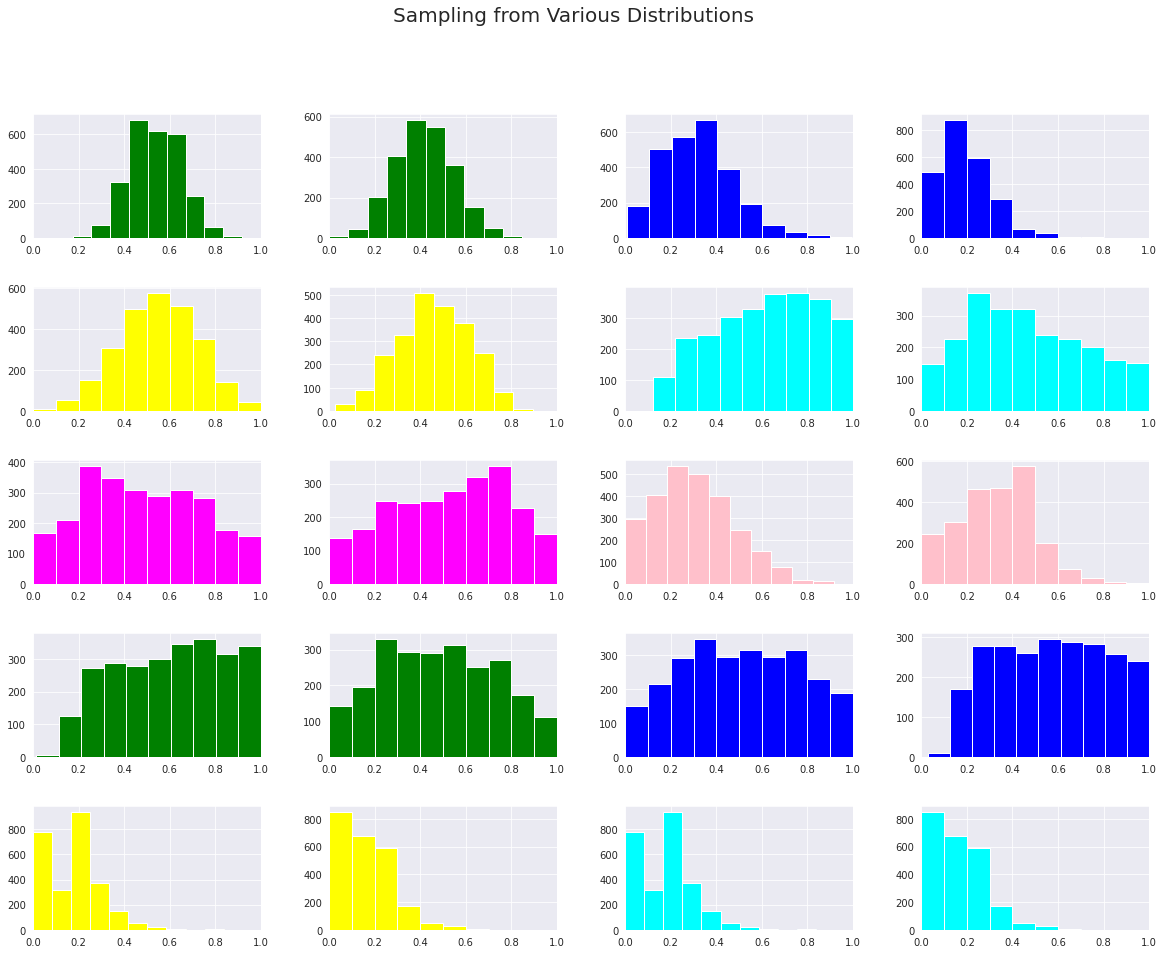

In [24]:
colors_list = ['green','blue','yellow','cyan','magenta','pink']

fig,ax = plt.subplots(nrows=np.ceil(config['data']['number_of_variables']*2/4).astype(int), ncols=4,figsize=(20,15))
for axis_1 in ax:
    for axis_2 in axis_1:
        axis_2.set_xlim([0, 1])                          

plot_index = 0

for i in range(X_data_list[rand_index][1].values.shape[1]):
    colors = colors_list[i%6]

    x = X_data_list[rand_index][1].values[:,i][np.where(random_network['model'].predict(X_data_list[rand_index][1].values).ravel()<=0.5)]
    plt.subplot(np.ceil(config['data']['number_of_variables']*2/4).astype(int), 4,plot_index+1)
    plt.hist(x,bins=10,color=colors)
    #plt.title(list(distribution_parameter.keys())[0] + ' Class 0' )
    plot_index += 1

    x = X_data_list[rand_index][1].values[:,i][np.where(random_network['model'].predict(X_data_list[rand_index][1].values).ravel()>0.5)]
    plt.subplot(np.ceil(config['data']['number_of_variables']*2/4).astype(int),4,plot_index+1)
    plt.hist(x,bins=10,color=colors)
    #plt.title(list(distribution_parameter.keys())[0] + ' Class 1' )
    plot_index += 1

fig.subplots_adjust(hspace=0.4,wspace=.3) 
plt.suptitle('Sampling from Various Distributions',fontsize=20)
plt.show()

In [25]:
distribution_parameter_list_list[0][1]

[{'uniform': {'class_0': {'low': 0.3867353463005374,
    'high': 0.690937738102466},
   'class_1': {'low': 0.3867353463005374, 'high': 0.690937738102466}}},
 {'uniform': {'class_0': {'low': 0.260829174830409,
    'high': 0.5166358912710143},
   'class_1': {'low': 0.260829174830409, 'high': 0.5166358912710143}}},
 {'binomial': {'class_0': {'n': 6.056522262372468, 'p': 0.16080805141749865},
   'class_1': {'n': 6.056522262372468, 'p': 0.16080805141749865}}},
 {'normal': {'class_0': {'loc': 4.972287313054103,
    'scale': 0.8796262633867269},
   'class_1': {'loc': 4.972287313054103, 'scale': 0.8796262633867269}}},
 {'exponential': {'class_0': {'scale': 4.53049393859277},
   'class_1': {'scale': 4.53049393859277}}},
 {'uniform': {'class_0': {'low': 0.1952429877980445,
    'high': 0.7224521152615053},
   'class_1': {'low': 0.1952429877980445, 'high': 0.7224521152615053}}},
 {'beta': {'class_0': {'a': 1.5846100257813882, 'b': 0.8474637334304624},
   'class_1': {'a': 1.5846100257813882, 'b': 0

In [26]:
#%load_ext autoreload
#%autoreload 2

In [27]:
parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky
clf_list = parallel(delayed(train_lambda_net)(config=config,
                                              lambda_index=index, 
                                              X_data_with_function=X_data, 
                                              y_data_with_function=y_data,
                                              distribution_parameter_list=distribution_parameter_list[1],
                                              return_history=True, 
                                              printing=True) for index, (X_data, y_data, distribution_parameter_list) in enumerate(zip(X_data_list, y_data_list, distribution_parameter_list_list)))  
del parallel

[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done  28 tasks      | elapsed:   32.7s
[Parallel(n_jobs=50)]: Done 188 tasks      | elapsed:  1.4min
[Parallel(n_jobs=50)]: Done 412 tasks      | elapsed:  2.5min
[Parallel(n_jobs=50)]: Done 700 tasks      | elapsed:  3.9min
[Parallel(n_jobs=50)]: Done 1052 tasks      | elapsed:  5.6min
[Parallel(n_jobs=50)]: Done 1468 tasks      | elapsed:  7.7min
[Parallel(n_jobs=50)]: Done 1948 tasks      | elapsed: 10.1min
[Parallel(n_jobs=50)]: Done 2492 tasks      | elapsed: 12.8min
[Parallel(n_jobs=50)]: Done 3100 tasks      | elapsed: 15.8min
[Parallel(n_jobs=50)]: Done 3772 tasks      | elapsed: 19.1min
[Parallel(n_jobs=50)]: Done 4508 tasks      | elapsed: 22.7min
[Parallel(n_jobs=50)]: Done 5308 tasks      | elapsed: 26.7min
[Parallel(n_jobs=50)]: Done 6172 tasks      | elapsed: 30.9min
[Parallel(n_jobs=50)]: Done 7100 tasks      | elapsed: 35.5min
[Parallel(n_jobs=50)]: Done 8092 tasks      |

In [28]:
random_network['model'].get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 10),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_input'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'batch_input_shape': (None, 10),
    'dtype': 'float32',
    'units': 128,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': 42}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'dtype': 'float32',
    'units': 1,
    'activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': 42}},
    'bias_initial

In [29]:
random_network['model'].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


## Save and Plot Lambda-Model History

In [30]:
loss_list_total = []
metric_list_total = []

val_loss_list_total = []
val_metric_list_total = []

index_list = []


max_training_epochs = 0
for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    max_training_epochs = max(max_training_epochs, current_training_epochs)


for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    index = entry['index']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    
    loss_list = np.full(max_training_epochs, np.nan)
    metric_list = np.full(max_training_epochs, np.nan)
    val_loss_list = np.full(max_training_epochs, np.nan)
    val_metric_list = np.full(max_training_epochs, np.nan) 

    for i in range(current_training_epochs):  
        loss_list[i] = history[list(history.keys())[0]][i]
        metric_list[i] = history[list(history.keys())[1]][i]
        val_loss_list[i] = history[list(history.keys())[len(history.keys())//2]][i]
        val_metric_list[i] = history[list(history.keys())[len(history.keys())//2+1]][i]
    
    index_list.append([index])
    loss_list_total.append(loss_list)
    metric_list_total.append(metric_list)
    val_loss_list_total.append(val_loss_list)
    val_metric_list_total.append(val_metric_list)

loss_df = pd.DataFrame(data=np.hstack([index_list, loss_list_total]), columns=flatten_list(['index', [list(history.keys())[0] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#loss_df['index'] = loss_df['index'].astype(int)
metric_df = pd.DataFrame(data=np.hstack([index_list, metric_list_total]), columns=flatten_list(['index', [list(history.keys())[1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#metric_df['index'] = metric_df['index'].astype(int)
val_loss_df = pd.DataFrame(data=np.hstack([index_list, val_loss_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#val_loss_df['index'] = val_loss_df['index'].astype(int)
val_metric_df = pd.DataFrame(data=np.hstack([index_list, val_metric_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2+1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]])) 
#val_metric_df['index'] = val_metric_df['index'].astype(int)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [31]:
path_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[0] + '.txt'
path_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[1] + '.txt'
path_val_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2] + '.txt'
path_val_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2+1] + '.txt'

loss_df.to_csv(path_loss, index=None, sep=',')
metric_df.to_csv(path_metric, index=None, sep=',')
val_loss_df.to_csv(path_val_loss, index=None, sep=',')
val_metric_df.to_csv(path_val_metric, index=None, sep=',')


In [32]:
loss_df.describe()

,index,loss_epoch_1,loss_epoch_2,loss_epoch_3,loss_epoch_4,loss_epoch_5,loss_epoch_6,loss_epoch_7,loss_epoch_8,loss_epoch_9,loss_epoch_10,loss_epoch_11,loss_epoch_12,loss_epoch_13,loss_epoch_14,loss_epoch_15,loss_epoch_16,loss_epoch_17,loss_epoch_18,loss_epoch_19,loss_epoch_20,loss_epoch_21,loss_epoch_22,loss_epoch_23,loss_epoch_24,loss_epoch_25,loss_epoch_26,loss_epoch_27,loss_epoch_28,loss_epoch_29,loss_epoch_30,loss_epoch_31,loss_epoch_32,loss_epoch_33,loss_epoch_34,loss_epoch_35,loss_epoch_36,loss_epoch_37,loss_epoch_38,loss_epoch_39,loss_epoch_40,loss_epoch_41,loss_epoch_42,loss_epoch_43,loss_epoch_44,loss_epoch_45,loss_epoch_46,loss_epoch_47,loss_epoch_48,loss_epoch_49,loss_epoch_50,loss_epoch_51,loss_epoch_52,loss_epoch_53,loss_epoch_54,loss_epoch_55,loss_epoch_56,loss_epoch_57,loss_epoch_58,loss_epoch_59,loss_epoch_60,loss_epoch_61,loss_epoch_62,loss_epoch_63,loss_epoch_64,loss_epoch_65,loss_epoch_66,loss_epoch_67,loss_epoch_68,loss_epoch_69,loss_epoch_70,loss_epoch_71,loss_epoch_72,loss_epoch_73,loss_epoch_74,loss_epoch_75,loss_epoch_76,loss_epoch_77,loss_epoch_78,loss_epoch_79,loss_epoch_80,loss_epoch_81,loss_epoch_82,loss_epoch_83,loss_epoch_84,loss_epoch_85,loss_epoch_86,loss_epoch_87,loss_epoch_88,loss_epoch_89,loss_epoch_90,loss_epoch_91,loss_epoch_92,loss_epoch_93,loss_epoch_94,loss_epoch_95,loss_epoch_96,loss_epoch_97,loss_epoch_98,loss_epoch_99,...,loss_epoch_516,loss_epoch_517,loss_epoch_518,loss_epoch_519,loss_epoch_520,loss_epoch_521,loss_epoch_522,loss_epoch_523,loss_epoch_524,loss_epoch_525,loss_epoch_526,loss_epoch_527,loss_epoch_528,loss_epoch_529,loss_epoch_530,loss_epoch_531,loss_epoch_532,loss_epoch_533,loss_epoch_534,loss_epoch_535,loss_epoch_536,loss_epoch_537,loss_epoch_538,loss_epoch_539,loss_epoch_540,loss_epoch_541,loss_epoch_542,loss_epoch_543,loss_epoch_544,loss_epoch_545,loss_epoch_546,loss_epoch_547,loss_epoch_548,loss_epoch_549,loss_epoch_550,loss_epoch_551,loss_epoch_552,loss_epoch_553,loss_epoch_554,loss_epoch_555,loss_epoch_556,loss_epoch_557,loss_epoch_558,loss_epoch_559,loss_epoch_560,loss_epoch_561,loss_epoch_562,loss_epoch_563,loss_epoch_564,loss_epoch_565,loss_epoch_566,loss_epoch_567,loss_epoch_568,loss_epoch_569,loss_epoch_570,loss_epoch_571,loss_epoch_572,loss_epoch_573,loss_epoch_574,loss_epoch_575,loss_epoch_576,loss_epoch_577,loss_epoch_578,loss_epoch_579,loss_epoch_580,loss_epoch_581,loss_epoch_582,loss_epoch_583,loss_epoch_584,loss_epoch_585,loss_epoch_586,loss_epoch_587,loss_epoch_588,loss_epoch_589,loss_epoch_590,loss_epoch_591,loss_epoch_592,loss_epoch_593,loss_epoch_594,loss_epoch_595,loss_epoch_596,loss_epoch_597,loss_epoch_598,loss_epoch_599,loss_epoch_600,loss_epoch_601,loss_epoch_602,loss_epoch_603,loss_epoch_604,loss_epoch_605,loss_epoch_606,loss_epoch_607,loss_epoch_608,loss_epoch_609,loss_epoch_610,loss_epoch_611,loss_epoch_612,loss_epoch_613,loss_epoch_614,loss_epoch_615
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,9999.000,9996.000,9991.000,9983.000,9977.000,9966.000,9961.000,9955.000,9940.000,9933.000,9925.000,9919.000,9910.000,9898.000,9885.000,9870.000,9864.000,9851.000,9840.000,9831.000,9814.000,9793.000,9783.000,9765.000,9739.000,9712.000,9696.000,9668.000,9637.000,9613.000,9585.000,9561.000,9521.000,9484.000,9451.000,9414.000,9372.000,9335.000,9290.000,9237.000,9179.000,9128.000,9077.000,9019.000,...,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.000,4.

In [33]:
val_loss_df.describe()

,index,val_loss_epoch_1,val_loss_epoch_2,val_loss_epoch_3,val_loss_epoch_4,val_loss_epoch_5,val_loss_epoch_6,val_loss_epoch_7,val_loss_epoch_8,val_loss_epoch_9,val_loss_epoch_10,val_loss_epoch_11,val_loss_epoch_12,val_loss_epoch_13,val_loss_epoch_14,val_loss_epoch_15,val_loss_epoch_16,val_loss_epoch_17,val_loss_epoch_18,val_loss_epoch_19,val_loss_epoch_20,val_loss_epoch_21,val_loss_epoch_22,val_loss_epoch_23,val_loss_epoch_24,val_loss_epoch_25,val_loss_epoch_26,val_loss_epoch_27,val_loss_epoch_28,val_loss_epoch_29,val_loss_epoch_30,val_loss_epoch_31,val_loss_epoch_32,val_loss_epoch_33,val_loss_epoch_34,val_loss_epoch_35,val_loss_epoch_36,val_loss_epoch_37,val_loss_epoch_38,val_loss_epoch_39,val_loss_epoch_40,val_loss_epoch_41,val_loss_epoch_42,val_loss_epoch_43,val_loss_epoch_44,val_loss_epoch_45,val_loss_epoch_46,val_loss_epoch_47,val_loss_epoch_48,val_loss_epoch_49,val_loss_epoch_50,val_loss_epoch_51,val_loss_epoch_52,val_loss_epoch_53,val_loss_epoch_54,val_loss_epoch_55,val_loss_epoch_56,val_loss_epoch_57,val_loss_epoch_58,val_loss_epoch_59,val_loss_epoch_60,val_loss_epoch_61,val_loss_epoch_62,val_loss_epoch_63,val_loss_epoch_64,val_loss_epoch_65,val_loss_epoch_66,val_loss_epoch_67,val_loss_epoch_68,val_loss_epoch_69,val_loss_epoch_70,val_loss_epoch_71,val_loss_epoch_72,val_loss_epoch_73,val_loss_epoch_74,val_loss_epoch_75,val_loss_epoch_76,val_loss_epoch_77,val_loss_epoch_78,val_loss_epoch_79,val_loss_epoch_80,val_loss_epoch_81,val_loss_epoch_82,val_loss_epoch_83,val_loss_epoch_84,val_loss_epoch_85,val_loss_epoch_86,val_loss_epoch_87,val_loss_epoch_88,val_loss_epoch_89,val_loss_epoch_90,val_loss_epoch_91,val_loss_epoch_92,val_loss_epoch_93,val_loss_epoch_94,val_loss_epoch_95,val_loss_epoch_96,val_loss_epoch_97,val_loss_epoch_98,val_loss_epoch_99,...,val_loss_epoch_516,val_loss_epoch_517,val_loss_epoch_518,val_loss_epoch_519,val_loss_epoch_520,val_loss_epoch_521,val_loss_epoch_522,val_loss_epoch_523,val_loss_epoch_524,val_loss_epoch_525,val_loss_epoch_526,val_loss_epoch_527,val_loss_epoch_528,val_loss_epoch_529,val_loss_epoch_530,val_loss_epoch_531,val_loss_epoch_532,val_loss_epoch_533,val_loss_epoch_534,val_loss_epoch_535,val_loss_epoch_536,val_loss_epoch_537,val_loss_epoch_538,val_loss_epoch_539,val_loss_epoch_540,val_loss_epoch_541,val_loss_epoch_542,val_loss_epoch_543,val_loss_epoch_544,val_loss_epoch_545,val_loss_epoch_546,val_loss_epoch_547,val_loss_epoch_548,val_loss_epoch_549,val_loss_epoch_550,val_loss_epoch_551,val_loss_epoch_552,val_loss_epoch_553,val_loss_epoch_554,val_loss_epoch_555,val_loss_epoch_556,val_loss_epoch_557,val_loss_epoch_558,val_loss_epoch_559,val_loss_epoch_560,val_loss_epoch_561,val_loss_epoch_562,val_loss_epoch_563,val_loss_epoch_564,val_loss_epoch_565,val_loss_epoch_566,val_loss_epoch_567,val_loss_epoch_568,val_loss_epoch_569,val_loss_epoch_570,val_loss_epoch_571,val_loss_epoch_572,val_loss_epoch_573,val_loss_epoch_574,val_loss_epoch_575,val_loss_epoch_576,val_loss_epoch_577,val_loss_epoch_578,val_loss_epoch_579,val_loss_epoch_580,val_loss_epoch_581,val_loss_epoch_582,val_loss_epoch_583,val_loss_epoch_584,val_loss_epoch_585,val_loss_epoch_586,val_loss_epoch_587,val_loss_epoch_588,val_loss_epoch_589,val_loss_epoch_590,val_loss_epoch_591,val_loss_epoch_592,val_loss_epoch_593,val_loss_epoch_594,val_loss_epoch_595,val_loss_epoch_596,val_loss_epoch_597,val_loss_epoch_598,val_loss_epoch_599,val_loss_epoch_600,val_loss_epoch_601,val_loss_epoch_602,val_loss_epoch_603,val_loss_epoch_604,val_loss_epoch_605,val_loss_epoch_606,val_loss_epoch_607,val_loss_epoch_608,val_loss_epoch_609,val_loss_epoch_610,val_loss_epoch_611,val_loss_epoch_612,val_loss_epoch_613,val_loss_epoch_614,val_loss_epoch_615
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,

In [34]:
metric_df.describe()

,index,binary_accuracy_epoch_1,binary_accuracy_epoch_2,binary_accuracy_epoch_3,binary_accuracy_epoch_4,binary_accuracy_epoch_5,binary_accuracy_epoch_6,binary_accuracy_epoch_7,binary_accuracy_epoch_8,binary_accuracy_epoch_9,binary_accuracy_epoch_10,binary_accuracy_epoch_11,binary_accuracy_epoch_12,binary_accuracy_epoch_13,binary_accuracy_epoch_14,binary_accuracy_epoch_15,binary_accuracy_epoch_16,binary_accuracy_epoch_17,binary_accuracy_epoch_18,binary_accuracy_epoch_19,binary_accuracy_epoch_20,binary_accuracy_epoch_21,binary_accuracy_epoch_22,binary_accuracy_epoch_23,binary_accuracy_epoch_24,binary_accuracy_epoch_25,binary_accuracy_epoch_26,binary_accuracy_epoch_27,binary_accuracy_epoch_28,binary_accuracy_epoch_29,binary_accuracy_epoch_30,binary_accuracy_epoch_31,binary_accuracy_epoch_32,binary_accuracy_epoch_33,binary_accuracy_epoch_34,binary_accuracy_epoch_35,binary_accuracy_epoch_36,binary_accuracy_epoch_37,binary_accuracy_epoch_38,binary_accuracy_epoch_39,binary_accuracy_epoch_40,binary_accuracy_epoch_41,binary_accuracy_epoch_42,binary_accuracy_epoch_43,binary_accuracy_epoch_44,binary_accuracy_epoch_45,binary_accuracy_epoch_46,binary_accuracy_epoch_47,binary_accuracy_epoch_48,binary_accuracy_epoch_49,binary_accuracy_epoch_50,binary_accuracy_epoch_51,binary_accuracy_epoch_52,binary_accuracy_epoch_53,binary_accuracy_epoch_54,binary_accuracy_epoch_55,binary_accuracy_epoch_56,binary_accuracy_epoch_57,binary_accuracy_epoch_58,binary_accuracy_epoch_59,binary_accuracy_epoch_60,binary_accuracy_epoch_61,binary_accuracy_epoch_62,binary_accuracy_epoch_63,binary_accuracy_epoch_64,binary_accuracy_epoch_65,binary_accuracy_epoch_66,binary_accuracy_epoch_67,binary_accuracy_epoch_68,binary_accuracy_epoch_69,binary_accuracy_epoch_70,binary_accuracy_epoch_71,binary_accuracy_epoch_72,binary_accuracy_epoch_73,binary_accuracy_epoch_74,binary_accuracy_epoch_75,binary_accuracy_epoch_76,binary_accuracy_epoch_77,binary_accuracy_epoch_78,binary_accuracy_epoch_79,binary_accuracy_epoch_80,binary_accuracy_epoch_81,binary_accuracy_epoch_82,binary_accuracy_epoch_83,binary_accuracy_epoch_84,binary_accuracy_epoch_85,binary_accuracy_epoch_86,binary_accuracy_epoch_87,binary_accuracy_epoch_88,binary_accuracy_epoch_89,binary_accuracy_epoch_90,binary_accuracy_epoch_91,binary_accuracy_epoch_92,binary_accuracy_epoch_93,binary_accuracy_epoch_94,binary_accuracy_epoch_95,binary_accuracy_epoch_96,binary_accuracy_epoch_97,binary_accuracy_epoch_98,binary_accuracy_epoch_99,...,binary_accuracy_epoch_516,binary_accuracy_epoch_517,binary_accuracy_epoch_518,binary_accuracy_epoch_519,binary_accuracy_epoch_520,binary_accuracy_epoch_521,binary_accuracy_epoch_522,binary_accuracy_epoch_523,binary_accuracy_epoch_524,binary_accuracy_epoch_525,binary_accuracy_epoch_526,binary_accuracy_epoch_527,binary_accuracy_epoch_528,binary_accuracy_epoch_529,binary_accuracy_epoch_530,binary_accuracy_epoch_531,binary_accuracy_epoch_532,binary_accuracy_epoch_533,binary_accuracy_epoch_534,binary_accuracy_epoch_535,binary_accuracy_epoch_536,binary_accuracy_epoch_537,binary_accuracy_epoch_538,binary_accuracy_epoch_539,binary_accuracy_epoch_540,binary_accuracy_epoch_541,binary_accuracy_epoch_542,binary_accuracy_epoch_543,binary_accuracy_epoch_544,binary_accuracy_epoch_545,binary_accuracy_epoch_546,binary_accuracy_epoch_547,binary_accuracy_epoch_548,binary_accuracy_epoch_549,binary_accuracy_epoch_550,binary_accuracy_epoch_551,binary_accuracy_epoch_552,binary_accuracy_epoch_553,binary_accuracy_epoch_554,binary_accuracy_epoch_555,binary_accuracy_epoch_556,binary_accuracy_epoch_557,binary_accuracy_epoch_558,binary_accuracy_epoch_559,binary_accuracy_epoch_560,binary_accuracy_epoch_561,binary_accuracy_epoch_562,binary_accuracy_epoch_563,binary_accuracy_epoch_564,binary_accuracy_epoch_565,binary_accuracy_epoch_566,binary_accuracy_epoch_567,binary_accuracy_epoch_568,binary_accuracy_epoch_569,binary_accuracy_epoch_570,binary_accuracy_epoch_571,binary_accuracy_epoch_572,binary_accuracy_epoch_573,binary_accuracy

In [35]:
val_metric_df.describe()

,index,val_binary_accuracy_epoch_1,val_binary_accuracy_epoch_2,val_binary_accuracy_epoch_3,val_binary_accuracy_epoch_4,val_binary_accuracy_epoch_5,val_binary_accuracy_epoch_6,val_binary_accuracy_epoch_7,val_binary_accuracy_epoch_8,val_binary_accuracy_epoch_9,val_binary_accuracy_epoch_10,val_binary_accuracy_epoch_11,val_binary_accuracy_epoch_12,val_binary_accuracy_epoch_13,val_binary_accuracy_epoch_14,val_binary_accuracy_epoch_15,val_binary_accuracy_epoch_16,val_binary_accuracy_epoch_17,val_binary_accuracy_epoch_18,val_binary_accuracy_epoch_19,val_binary_accuracy_epoch_20,val_binary_accuracy_epoch_21,val_binary_accuracy_epoch_22,val_binary_accuracy_epoch_23,val_binary_accuracy_epoch_24,val_binary_accuracy_epoch_25,val_binary_accuracy_epoch_26,val_binary_accuracy_epoch_27,val_binary_accuracy_epoch_28,val_binary_accuracy_epoch_29,val_binary_accuracy_epoch_30,val_binary_accuracy_epoch_31,val_binary_accuracy_epoch_32,val_binary_accuracy_epoch_33,val_binary_accuracy_epoch_34,val_binary_accuracy_epoch_35,val_binary_accuracy_epoch_36,val_binary_accuracy_epoch_37,val_binary_accuracy_epoch_38,val_binary_accuracy_epoch_39,val_binary_accuracy_epoch_40,val_binary_accuracy_epoch_41,val_binary_accuracy_epoch_42,val_binary_accuracy_epoch_43,val_binary_accuracy_epoch_44,val_binary_accuracy_epoch_45,val_binary_accuracy_epoch_46,val_binary_accuracy_epoch_47,val_binary_accuracy_epoch_48,val_binary_accuracy_epoch_49,val_binary_accuracy_epoch_50,val_binary_accuracy_epoch_51,val_binary_accuracy_epoch_52,val_binary_accuracy_epoch_53,val_binary_accuracy_epoch_54,val_binary_accuracy_epoch_55,val_binary_accuracy_epoch_56,val_binary_accuracy_epoch_57,val_binary_accuracy_epoch_58,val_binary_accuracy_epoch_59,val_binary_accuracy_epoch_60,val_binary_accuracy_epoch_61,val_binary_accuracy_epoch_62,val_binary_accuracy_epoch_63,val_binary_accuracy_epoch_64,val_binary_accuracy_epoch_65,val_binary_accuracy_epoch_66,val_binary_accuracy_epoch_67,val_binary_accuracy_epoch_68,val_binary_accuracy_epoch_69,val_binary_accuracy_epoch_70,val_binary_accuracy_epoch_71,val_binary_accuracy_epoch_72,val_binary_accuracy_epoch_73,val_binary_accuracy_epoch_74,val_binary_accuracy_epoch_75,val_binary_accuracy_epoch_76,val_binary_accuracy_epoch_77,val_binary_accuracy_epoch_78,val_binary_accuracy_epoch_79,val_binary_accuracy_epoch_80,val_binary_accuracy_epoch_81,val_binary_accuracy_epoch_82,val_binary_accuracy_epoch_83,val_binary_accuracy_epoch_84,val_binary_accuracy_epoch_85,val_binary_accuracy_epoch_86,val_binary_accuracy_epoch_87,val_binary_accuracy_epoch_88,val_binary_accuracy_epoch_89,val_binary_accuracy_epoch_90,val_binary_accuracy_epoch_91,val_binary_accuracy_epoch_92,val_binary_accuracy_epoch_93,val_binary_accuracy_epoch_94,val_binary_accuracy_epoch_95,val_binary_accuracy_epoch_96,val_binary_accuracy_epoch_97,val_binary_accuracy_epoch_98,val_binary_accuracy_epoch_99,...,val_binary_accuracy_epoch_516,val_binary_accuracy_epoch_517,val_binary_accuracy_epoch_518,val_binary_accuracy_epoch_519,val_binary_accuracy_epoch_520,val_binary_accuracy_epoch_521,val_binary_accuracy_epoch_522,val_binary_accuracy_epoch_523,val_binary_accuracy_epoch_524,val_binary_accuracy_epoch_525,val_binary_accuracy_epoch_526,val_binary_accuracy_epoch_527,val_binary_accuracy_epoch_528,val_binary_accuracy_epoch_529,val_binary_accuracy_epoch_530,val_binary_accuracy_epoch_531,val_binary_accuracy_epoch_532,val_binary_accuracy_epoch_533,val_binary_accuracy_epoch_534,val_binary_accuracy_epoch_535,val_binary_accuracy_epoch_536,val_binary_accuracy_epoch_537,val_binary_accuracy_epoch_538,val_binary_accuracy_epoch_539,val_binary_accuracy_epoch_540,val_binary_accuracy_epoch_541,val_binary_accuracy_epoch_542,val_binary_accuracy_epoch_543,val_binary_accuracy_epoch_544,val_binary_accuracy_epoch_545,val_binary_accuracy_epoch_546,val_binary_accuracy_epoch_547,val_binary_accuracy_epoch_548,val_binary_accuracy_epoch_549,val_binary_accuracy_epoch_550,val_binary_accuracy_epoch_551,val_binary_accuracy_epoch_552,val_binary_accura

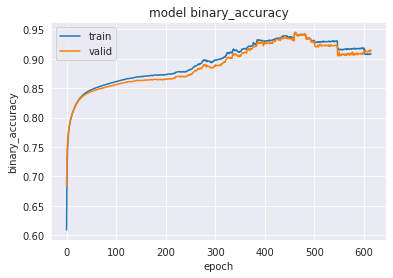

In [36]:
# summarize history for metric
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[1] + '.png'

adjustment_threshold_metric = 10#100
    
metric_df_adjusted = metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    metric_df_adjusted[metric_df_adjusted.columns] = np.where(metric_df_adjusted[metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, metric_df_adjusted[metric_df_adjusted.columns])
    
val_metric_df_adjusted = val_metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    val_metric_df_adjusted[val_metric_df_adjusted.columns] = np.where(val_metric_df_adjusted[val_metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, val_metric_df_adjusted[val_metric_df_adjusted.columns])

    
plt.plot(metric_df_adjusted.describe().loc['mean'].values)
plt.plot(val_metric_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[1])
plt.ylabel(list(history.keys())[1])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


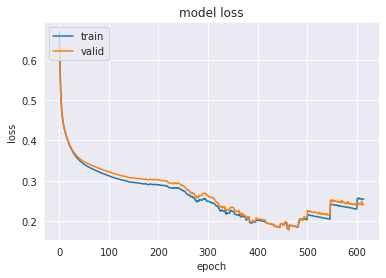

In [37]:
# summarize history for loss
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[0] + '.png'

adjustment_threshold_loss = 0#10000
    
loss_df_adjusted = loss_df.copy(deep=True).iloc[:,1:]

if adjustment_threshold_loss > 0:
    loss_df_adjusted[loss_df_adjusted.columns] = np.where(loss_df_adjusted[loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, loss_df_adjusted[loss_df_adjusted.columns])
    
val_loss_df_adjusted = val_loss_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_loss > 0:
    val_loss_df_adjusted[val_loss_df_adjusted.columns] = np.where(val_loss_df_adjusted[val_loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, val_loss_df_adjusted[val_loss_df_adjusted.columns])

    
plt.plot(loss_df_adjusted.describe().loc['mean'].values)
plt.plot(val_loss_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[0])
plt.ylabel(list(history.keys())[0])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()
